<a href="https://colab.research.google.com/github/rui2333/229_project_cfps/blob/main/cross%26deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This note book focus on implementing DCN for the CFPS dataset.


# Deep and Cross network for CFPS
## _Feature engineering network_

DCN was designed to learn explicit and bounded-degree cross features more effectively. It starts with an input layer (typically an embedding layer), followed by a cross network containing multiple cross layers that models explicit feature interactions, and then combines with a deep network that models implicit feature interactions.

- Deep and Cross Network
- Implementation details

## Introduction to data

### Pre-processing
Steps for pre-processing data
* Split data by training, validating, and testing set.
* Remove data that contains personal information.
* Drop all the nan data
* Split ground truth with feature set.

#### Environment setup

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

import pandas as pd
import numpy as np
import pprint

%matplotlib inline
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs
import tensorflow_addons as tfa

In [2]:
y_cols = ['qn406','qn407','qn411','qn412','qn414','qn416','qn418','qn420']
y_cols_dsm = ['qn406','qn407','qn411','qn412','qn414','qn416','qn418','qn420','dsm_diagnosis']
personal_info_cols = ['pid', 'code', 'fid18', 'fid16', 'fid14', 'fid12', 'fid10', 'pid_a_f', 'pid_a_m', 'releaseversion', 'interviewerid18']
data_path = "/content/drive/MyDrive/Colab Notebooks/ecfps2018person_202012.dta"
training_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

#### Helper function in pre-processing

In [3]:
def load_dta(dta_path):
    """Load dataset into a pandas dataframe"""

    data=pd.read_stata(dta_path,
                       convert_categoricals=False,
                       preserve_dtypes=False
                      )
    return data

def drop_personal_info(data):
    """Drop personal info related columns"""
    return data.drop(personal_info_cols, axis=1)

def clean_up_na_values(data):
    """Remove all the rows that contains nan value"""
    data.replace('', np.nan, inplace=True)
    ground_truth, _ = split_groud_truth(data)
    data = data.dropna(axis=1)
    data = data.join(ground_truth)
    data = data.dropna()
    return data.astype('float32')

def split_groud_truth(data):
    """Separate ground truth with traning features"""
    return data[y_cols], data.drop(y_cols, axis=1)

def split_groud_truth_dsm(data):
    """Separate ground truth with traning features"""
    return data[y_cols_dsm], data.drop(y_cols_dsm, axis=1)


def map_cfps_dsm(data):
    """Map Groundtruth Questions to DSMV"""

    n, n_col = data.shape
    print(data.shape)

    dsm_diagnosis = []

    for idx, row in data.iterrows():# for every datapoint
        num_symptoms = 0
        basic_criterion = 0

        # Minimum Must-Meet Criterion for Major Depression -------
        # 'qn406': "I'm in a low spirit (Dysphoria)"
        # 'qn418': "I feel sad (Dysphoria & Anhedonia)"
        if row['qn406'] == 4 or row['qn418'] == 4:
            basic_criterion = 1

        # Additional Symptoms for 'qn406' & 'qn418'----------------
        if row['qn406'] == 4 and row['qn418'] == 4:
            num_symptoms += 1

        elif row['qn406'] == 3 and row['qn418'] == 3:
            num_symptoms += 2

        elif row['qn406'] == 3 and row['qn418'] != 3:
            num_symptoms += 1

        elif row['qn406'] != 3 and row['qn418'] == 3:
            num_symptoms += 1

        #---------------------------------------------------
        # Symptoms for 'qn407': "I find it difficult to do anything"
        if row['qn407'] >= 3:
            num_symptoms += 4

        # Symptoms for 'qn411': "I cannot sleep well"
        if row['qn411'] >= 3:
            num_symptoms += 2

        # Symptoms for 'qn414': "I feel lonely"
        if row['qn414'] == 4:
            num_symptoms += 1

        # Symptoms for 'qn420': "I feel that I cannot continue with my life"
        if row['qn420'] >= 3:
            num_symptoms += 5

        # Symptoms for 'qn412': "I feel happy (REVERSED)"
        if row['qn412'] == 4:
            num_symptoms += 2

        # Symptoms for 'qn416': "I have a happy life (REVERSED)"
        if row['qn416'] == 4:
            num_symptoms += 2

        #---------------------------------------------------
        # DSM Diagnosis Categories:
        #  -- 4 --  Major Depressive Episode
        #  -- 3 --  Probably Major Depressive Episode
        #  -- 2 --  Possible Major Depressive Episode
        #  -- 1 --  Subthreshold Depression Symptoms
        #  -- 0 --  No Clinical Significance

        if basic_criterion == 1 and num_symptoms >= 4:
            dsm_diagnosis.append(4)

        elif basic_criterion == 1 and num_symptoms == 3:
            dsm_diagnosis.append(3)

        elif basic_criterion == 1 and num_symptoms == 2:
            dsm_diagnosis.append(2)

        elif basic_criterion != 1 and num_symptoms >= 4:
            dsm_diagnosis.append(1)

        elif basic_criterion != 1 and num_symptoms < 4:
            dsm_diagnosis.append(0)

        else:
            dsm_diagnosis.append(0)

    return dsm_diagnosis  #numpy list

#### Prepare data

In [4]:
def pre_process():
    data = load_dta(data_path)
    data = drop_personal_info(data)
    data = clean_up_na_values(data)
    y, x = split_groud_truth(data)

    # split data for different purpose
    training_dataset = (
        tf.data.Dataset.from_tensor_slices(
            (
                dict(x[: round(training_ratio * len(x))]),
                dict(y[: round(training_ratio * len(y))])
            )
        )
    )
    validataion_dataset = (
        tf.data.Dataset.from_tensor_slices(
            (
                dict(x[round(training_ratio * len(x)): round((training_ratio + validation_ratio) * len(x))]),
                dict(y[round(training_ratio * len(x)): round((training_ratio + validation_ratio) * len(y))])
            )
        )  
    )
    test_dataset = (
        tf.data.Dataset.from_tensor_slices(
            (
                dict(x[round((training_ratio + validation_ratio) * len(x)):]),
                dict(y[round((training_ratio + validation_ratio) * len(y)):])
            )
        )
    )
    return training_dataset, validataion_dataset, test_dataset, list(x.columns.values), list(y.columns.values)
    
def pre_process_dsm():
    data = load_dta(data_path)
    data = drop_personal_info(data)
    data = clean_up_na_values(data)
    dsm_diagnosis = map_cfps_dsm(data)
    data["dsm_diagnosis"] = dsm_diagnosis
    y, x = split_groud_truth_dsm(data)
    
    # split data for different purpose
    training_dataset = (
        tf.data.Dataset.from_tensor_slices(
            (
                dict(x[: round(training_ratio * len(x))]),
                dict(y[: round(training_ratio * len(y))])
            )
        )
    )
    validataion_dataset = (
        tf.data.Dataset.from_tensor_slices(
            (
                dict(x[round(training_ratio * len(x)): round((training_ratio + validation_ratio) * len(x))]),
                dict(y[round(training_ratio * len(x)): round((training_ratio + validation_ratio) * len(y))])
            )
        )  
    )
    test_dataset = (
        tf.data.Dataset.from_tensor_slices(
            (
                dict(x[round((training_ratio + validation_ratio) * len(x)):]),
                dict(y[round((training_ratio + validation_ratio) * len(y)):])
            )
        )
    )
    return training_dataset, validataion_dataset, test_dataset, list(x.columns.values), list(y.columns.values)

training, validataion, test, features, labels = pre_process()
training_dsm, validataion_dsm, test_dsm, features_dsm, labels_dsm = pre_process_dsm()
print(labels_dsm)

(33097, 43)
['qn406', 'qn407', 'qn411', 'qn412', 'qn414', 'qn416', 'qn418', 'qn420', 'dsm_diagnosis']


In [5]:
def extract_features_from_tensor(dataset):
    return dataset.map(lambda l, d: {
        "selfrpt": l["selfrpt"],
        "proxyrpt": l["proxyrpt"],
        "interrupt": l["interrupt"],
        "subsample": l["subsample"],
        "subpopulation": l["subpopulation"],
        "urban18": l["urban18"],
        "psu": l["psu"],
        "tb6_a18_p": l["tb6_a18_p"],
        "outunit18": l["outunit18"],
        "gene": l["gene"],
        "gender": l["gender"],
        "minzu": l["minzu"],
        "retire": l["retire"],
        "pension": l["pension"],
        "party": l["party"],
        "cyear": l["cyear"],
        "cmonth": l["cmonth"],
        "age": l["age"],
        "qa701code": l["qa701code"],
        "qc1": l["qc1"],
        "qc2": l["qc2"],
        "school": l["school"],
        "qc3": l["qc3"],
        "qc4": l["qc4"],
        "qc5": l["qc5"],
        "qgb1": l["qgb1"],
        "qg1": l["qg1"],
        "qg101": l["qg101"],
        "qg2": l["qg2"],
        "qg201": l["qg201"],
        "qg12": l["qg12"],
        "qi101": l["qi101"],
        "qi1011": l["qi1011"],
        "qn4001": l["qn4001"],
        "qp201": l["qp201"],
        "qn406": d["qn406"],
        "qn407": d["qn407"],
        "qn411": d["qn411"],
        "qn412": d["qn412"],
        "qn414": d["qn414"],
        "qn416": d["qn416"],
        "qn418": d["qn418"],
        "qn420": d["qn420"],
    })

training = extract_features_from_tensor(training)
validataion = extract_features_from_tensor(validataion)
test = extract_features_from_tensor(test)

def extract_features_from_tensor_dsm(dataset):
    return dataset.map(lambda l, d: {
        "selfrpt": l["selfrpt"],
        "proxyrpt": l["proxyrpt"],
        "interrupt": l["interrupt"],
        "subsample": l["subsample"],
        "subpopulation": l["subpopulation"],
        "urban18": l["urban18"],
        "psu": l["psu"],
        "tb6_a18_p": l["tb6_a18_p"],
        "outunit18": l["outunit18"],
        "gene": l["gene"],
        "gender": l["gender"],
        "minzu": l["minzu"],
        "retire": l["retire"],
        "pension": l["pension"],
        "party": l["party"],
        "cyear": l["cyear"],
        "cmonth": l["cmonth"],
        "age": l["age"],
        "qa701code": l["qa701code"],
        "qc1": l["qc1"],
        "qc2": l["qc2"],
        "school": l["school"],
        "qc3": l["qc3"],
        "qc4": l["qc4"],
        "qc5": l["qc5"],
        "qgb1": l["qgb1"],
        "qg1": l["qg1"],
        "qg101": l["qg101"],
        "qg2": l["qg2"],
        "qg201": l["qg201"],
        "qg12": l["qg12"],
        "qi101": l["qi101"],
        "qi1011": l["qi1011"],
        "qn4001": l["qn4001"],
        "qp201": l["qp201"],
        "qn406": d["qn406"],
        "qn407": d["qn407"],
        "qn411": d["qn411"],
        "qn412": d["qn412"],
        "qn414": d["qn414"],
        "qn416": d["qn416"],
        "qn418": d["qn418"],
        "qn420": d["qn420"],
        "dsm_diagnosis": d["dsm_diagnosis"],
    })

training_dsm = extract_features_from_tensor_dsm(training_dsm)
validataion_dsm = extract_features_from_tensor_dsm(validataion_dsm)
test_dsm = extract_features_from_tensor_dsm(test_dsm)

In [6]:
vocabularies = {}

for feature_name in features:
    vocab = training.batch(len(training)).map(lambda d: d[feature_name])
    vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

#### Model *construction*

Multi-class implementation

In [27]:

class DCN(tfrs.Model):
    def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
        super().__init__()

        self.embedding_dimension = 32

        self._all_features = features
        self._embeddings = {}
        
        # Compute embeddings for features.
        for feature_name in features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                [tf.keras.layers.IntegerLookup(
                    vocabulary=vocabulary, mask_token=None, oov_token=-1000),
                tf.keras.layers.Embedding(len(vocabulary) + 1,
                                            self.embedding_dimension)
            ])

        if use_cross_layer:
            self._cross_layer = tfrs.layers.dcn.Cross(
                projection_dim=projection_dim,
                kernel_initializer="glorot_uniform")
        else:
            self._cross_layer = None

        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layer_sizes]

        self._logit_layer = [tf.keras.layers.Dense(1) for i in range(8)]

        self.task = [tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
        ) for i in range(8)]

    def call(self, features):
        # Concatenate embeddings
        embeddings = []
        for feature_name in self._all_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))

        x = tf.concat(embeddings, axis=1)

        # Build Cross Network
        if self._cross_layer is not None:
            x = self._cross_layer(x)
        
        # Build Deep Network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)

        return [self._logit_layer[i](x) for i in range(8)]

    def compute_loss(self, features, training=False):
        labels = [features.pop("qn406"), 
                  features.pop("qn407"), 
                  features.pop("qn411"), 
                  features.pop("qn412"), 
                  features.pop("qn414"), 
                  features.pop("qn416"), 
                  features.pop("qn418"), 
                  features.pop("qn420")]
        scores = self(features)
        #self.compute_f1_score(scores, labels)
        return sum([self.task[i](
            labels=labels[i],
            predictions=scores[i],
        ) for i in range(8)])/8
    
    def compute_f1_score(self, predictions, labels):
        metric = [tfa.metrics.F1Score(num_classes=1, threshold=0.5) for i in range(8)]
        for i in range (8):
            metric[i].update_state(labels[i], predictions[i])
        result = [metric[i].result() for i in range (8)]
        print(result.numpy())

Multi-class implementation - 2


In [28]:
class DCN_2(tfrs.Model):
    def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
        super().__init__()

        self.embedding_dimension = 32

        self._all_features = features
        self._embeddings = {}
        
        # Compute embeddings for features.
        for feature_name in features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                [tf.keras.layers.IntegerLookup(
                    vocabulary=vocabulary, mask_token=None, oov_token=-1000),
                tf.keras.layers.Embedding(len(vocabulary) + 1,
                                            self.embedding_dimension)
            ])

        if use_cross_layer:
            self._cross_layer = tfrs.layers.dcn.Cross(
                projection_dim=projection_dim,
                kernel_initializer="glorot_uniform")
        else:
            self._cross_layer = None

        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layer_sizes]

        self._logit_layer = [tf.keras.layers.Dense(1) for i in range(8)]

        self.task = [tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
        ) for i in range(8)]

    def call(self, features):
        # Concatenate embeddings
        embeddings = []
        for feature_name in self._all_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))

        x = tf.concat(embeddings, axis=1)

        # Build Cross Network
        if self._cross_layer is not None:
            x = self._cross_layer(x)
        
        # Build Deep Network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)

        return [self._logit_layer[i](x) for i in range(8)]

    def compute_loss(self, features, training=False):
        labels = [features.pop("qn406"), 
                  features.pop("qn407"), 
                  features.pop("qn411"), 
                  features.pop("qn412"), 
                  features.pop("qn414"), 
                  features.pop("qn416"), 
                  features.pop("qn418"), 
                  features.pop("qn420")]
        scores = self(features)
        #self.compute_f1_score(scores, labels)
        return sum([self.task[i](
            labels=labels[i],
            predictions=scores[i],
        ) for i in range(8)])
    
    def compute_f1_score(self, predictions, labels):
        metric = [tfa.metrics.F1Score(num_classes=1, threshold=0.5) for i in range(8)]
        for i in range (8):
            metric[i].update_state(labels[i], predictions[i])
        result = [metric[i].result() for i in range (8)]
        print(result.numpy())

Cast the class to DESC scores

In [29]:
class DCN_3(tfrs.Model):
    def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
        super().__init__()

        self.embedding_dimension = 32

        self._all_features = features
        self._embeddings = {}
        
        # Compute embeddings for features.
        for feature_name in features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                [tf.keras.layers.IntegerLookup(
                    vocabulary=vocabulary, mask_token=None, oov_token=-1000),
                tf.keras.layers.Embedding(len(vocabulary) + 1,
                                          self.embedding_dimension)
            ])

        if use_cross_layer:
            self._cross_layer = tfrs.layers.dcn.Cross(
                projection_dim=projection_dim,
                kernel_initializer="glorot_uniform")
        else:
            self._cross_layer = None

        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layer_sizes]

        self._logit_layer = tf.keras.layers.Dense(1)

        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
        )

    def call(self, features):
        # Concatenate embeddings
        embeddings = []
        for feature_name in self._all_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))

        x = tf.concat(embeddings, axis=1)

        # Build Cross Network
        if self._cross_layer is not None:
            x = self._cross_layer(x)
        
        # Build Deep Network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)

        return self._logit_layer(x)

    def compute_loss(self, features, training=False):
        labels = features.pop("dsm_diagnosis")
        scores = self(features)
        return self.task(
            labels=labels,
            predictions=scores,
            )

#### Train the model

In [10]:
cached_training = training.shuffle(len(training)).batch(8192).cache()
cached_test = test.batch(4096).cache()
cached_training_dsm = training_dsm.shuffle(len(training_dsm)).batch(8192).cache()
cached_test_dsm = test_dsm.batch(4096).cache()

In [34]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
    models = []
    rmses = []

    for i in range(num_runs):
        model_1 = DCN(use_cross_layer=use_cross_layer,
                    deep_layer_sizes=deep_layer_sizes,
                    projection_dim=projection_dim)
        model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))

        model_2 = DCN_2(use_cross_layer=use_cross_layer,
                    deep_layer_sizes=deep_layer_sizes,
                    projection_dim=projection_dim)
        model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))

        model_3 = DCN_3(use_cross_layer=use_cross_layer,
                    deep_layer_sizes=deep_layer_sizes,
                    projection_dim=projection_dim)
        model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
        models.append(model_1)
        models.append(model_2)
        models.append(model_3)

        print("Model 1")
        print("="*30)
        model_1.fit(cached_training, epochs=epochs, verbose=False)
        metrics = model_1.evaluate(cached_test, return_dict=True)
        rmses.append(metrics["RMSE"])
        print("Model 2")
        print("="*30)
        model_2.fit(cached_training, epochs=epochs, verbose=False)
        metrics = model_2.evaluate(cached_test, return_dict=True)
        rmses.append(metrics["RMSE"])
        print("Model 3")
        print("="*30)
        model_3.fit(cached_training_dsm, epochs=epochs, verbose=False)
        metrics = model_3.evaluate(cached_test_dsm, return_dict=True)
        rmses.append(metrics["RMSE"])

    mean, stdv = np.average(rmses), np.std(rmses)

    return {"model": models, "mean": mean, "stdv": stdv}

In [35]:
epochs = 8
learning_rate = 0.01
dcn_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192])

Model 1
2/2 [==============================] - 1s 156ms/step - RMSE: 1.0083 - loss: 1.5985 - regularization_loss: 0.0000e+00 - total_loss: 1.5985
Model 2
2/2 [==============================] - 1s 169ms/step - RMSE: 0.7788 - loss: 9.0900 - regularization_loss: 0.0000e+00 - total_loss: 9.0900
Model 3
2/2 [==============================] - 1s 162ms/step - RMSE: 0.9593 - loss: 0.8964 - regularization_loss: 0.0000e+00 - total_loss: 0.8964
Model 1
2/2 [==============================] - 1s 152ms/step - RMSE: 1.1668 - loss: 1.5118 - regularization_loss: 0.0000e+00 - total_loss: 1.5118
Model 2
2/2 [==============================] - 1s 145ms/step - RMSE: 1.0852 - loss: 12.6028 - regularization_loss: 0.0000e+00 - total_loss: 12.6028
Model 3
2/2 [==============================] - 1s 147ms/step - RMSE: 0.9461 - loss: 0.8844 - regularization_loss: 0.0000e+00 - total_loss: 0.8844
Model 1
2/2 [==============================] - 1s 152ms/step - RMSE: 1.1267 - loss: 1.4838 - regularization_loss: 0.0000e+

In [36]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

Model 1
2/2 [==============================] - 1s 69ms/step - RMSE: 1.1366 - loss: 1.5517 - regularization_loss: 0.0000e+00 - total_loss: 1.5517
Model 2
2/2 [==============================] - 1s 56ms/step - RMSE: 1.1395 - loss: 12.5390 - regularization_loss: 0.0000e+00 - total_loss: 12.5390
Model 3
2/2 [==============================] - 1s 56ms/step - RMSE: 0.9389 - loss: 0.8752 - regularization_loss: 0.0000e+00 - total_loss: 0.8752
Model 1
2/2 [==============================] - 1s 66ms/step - RMSE: 1.1297 - loss: 1.4713 - regularization_loss: 0.0000e+00 - total_loss: 1.4713
Model 2
2/2 [==============================] - 1s 57ms/step - RMSE: 1.0468 - loss: 11.1905 - regularization_loss: 0.0000e+00 - total_loss: 11.1905
Model 3
2/2 [==============================] - 1s 59ms/step - RMSE: 0.9346 - loss: 0.8639 - regularization_loss: 0.0000e+00 - total_loss: 0.8639
Model 1
2/2 [==============================] - 1s 58ms/step - RMSE: 1.0922 - loss: 1.5755 - regularization_loss: 0.0000e+00 - 

In [37]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

Model 1
2/2 [==============================] - 1s 58ms/step - RMSE: 1.0439 - loss: 1.5683 - regularization_loss: 0.0000e+00 - total_loss: 1.5683
Model 2
2/2 [==============================] - 1s 42ms/step - RMSE: 1.1700 - loss: 12.4540 - regularization_loss: 0.0000e+00 - total_loss: 12.4540
Model 3
2/2 [==============================] - 1s 48ms/step - RMSE: 0.9335 - loss: 0.8638 - regularization_loss: 0.0000e+00 - total_loss: 0.8638
Model 1
2/2 [==============================] - 1s 44ms/step - RMSE: 1.0350 - loss: 1.5643 - regularization_loss: 0.0000e+00 - total_loss: 1.5643
Model 2
2/2 [==============================] - 1s 44ms/step - RMSE: 1.0662 - loss: 12.0011 - regularization_loss: 0.0000e+00 - total_loss: 12.0011
Model 3
2/2 [==============================] - 1s 40ms/step - RMSE: 0.9448 - loss: 0.8862 - regularization_loss: 0.0000e+00 - total_loss: 0.8862
Model 1
2/2 [==============================] - 1s 44ms/step - RMSE: 1.2720 - loss: 1.5763 - regularization_loss: 0.0000e+00 - 

In [38]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))

DCN            RMSE mean: 1.0256, stdv: 0.1312
DCN (low-rank) RMSE mean: 1.0622, stdv: 0.0914
DNN            RMSE mean: 1.0664, stdv: 0.1097


ListWrapper(['selfrpt', 'proxyrpt', 'interrupt', 'subsample', 'subpopulation', 'urban18', 'psu', 'tb6_a18_p', 'outunit18', 'gene', 'gender', 'minzu', 'retire', 'pension', 'party', 'cyear', 'cmonth', 'age', 'qa701code', 'qc1', 'qc2', 'school', 'qc3', 'qc4', 'qc5', 'qgb1', 'qg1', 'qg101', 'qg2', 'qg201', 'qg12', 'qi101', 'qi1011', 'qn4001', 'qp201'])


<Figure size 14400x14400 with 0 Axes>

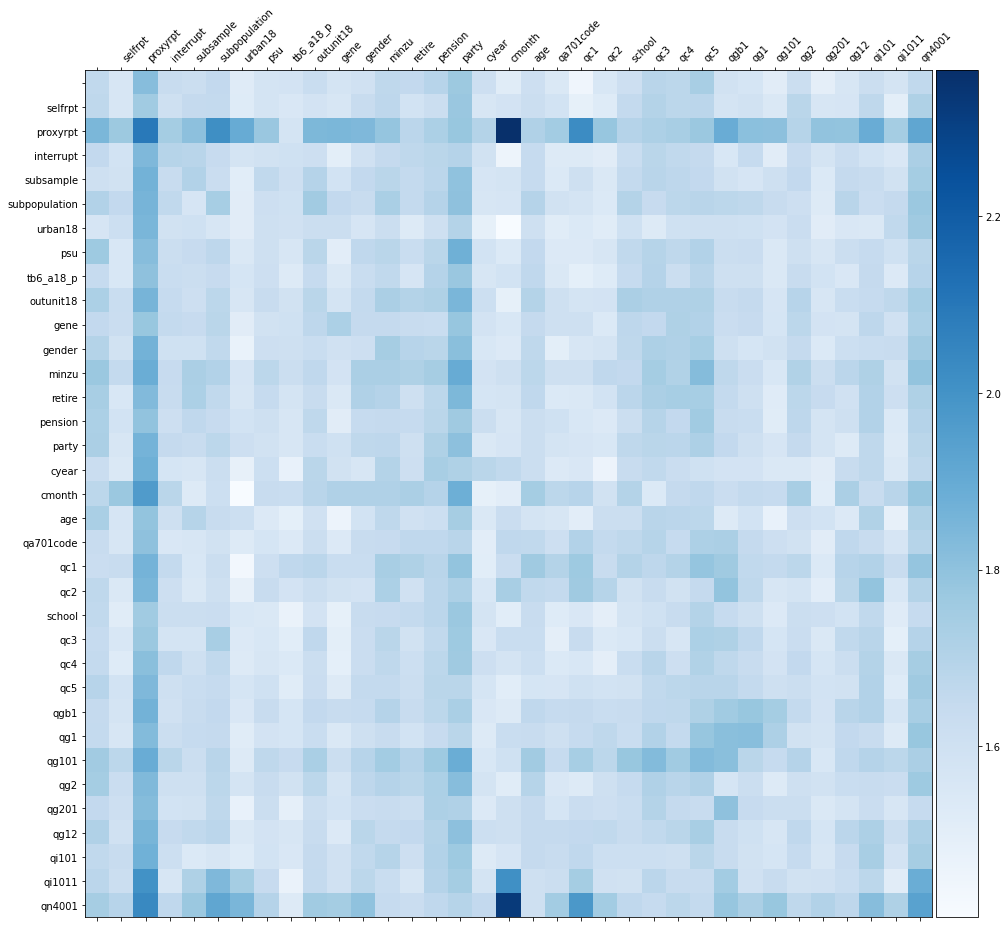

ListWrapper(['selfrpt', 'proxyrpt', 'interrupt', 'subsample', 'subpopulation', 'urban18', 'psu', 'tb6_a18_p', 'outunit18', 'gene', 'gender', 'minzu', 'retire', 'pension', 'party', 'cyear', 'cmonth', 'age', 'qa701code', 'qc1', 'qc2', 'school', 'qc3', 'qc4', 'qc5', 'qgb1', 'qg1', 'qg101', 'qg2', 'qg201', 'qg12', 'qi101', 'qi1011', 'qn4001', 'qp201'])


<Figure size 14400x14400 with 0 Axes>

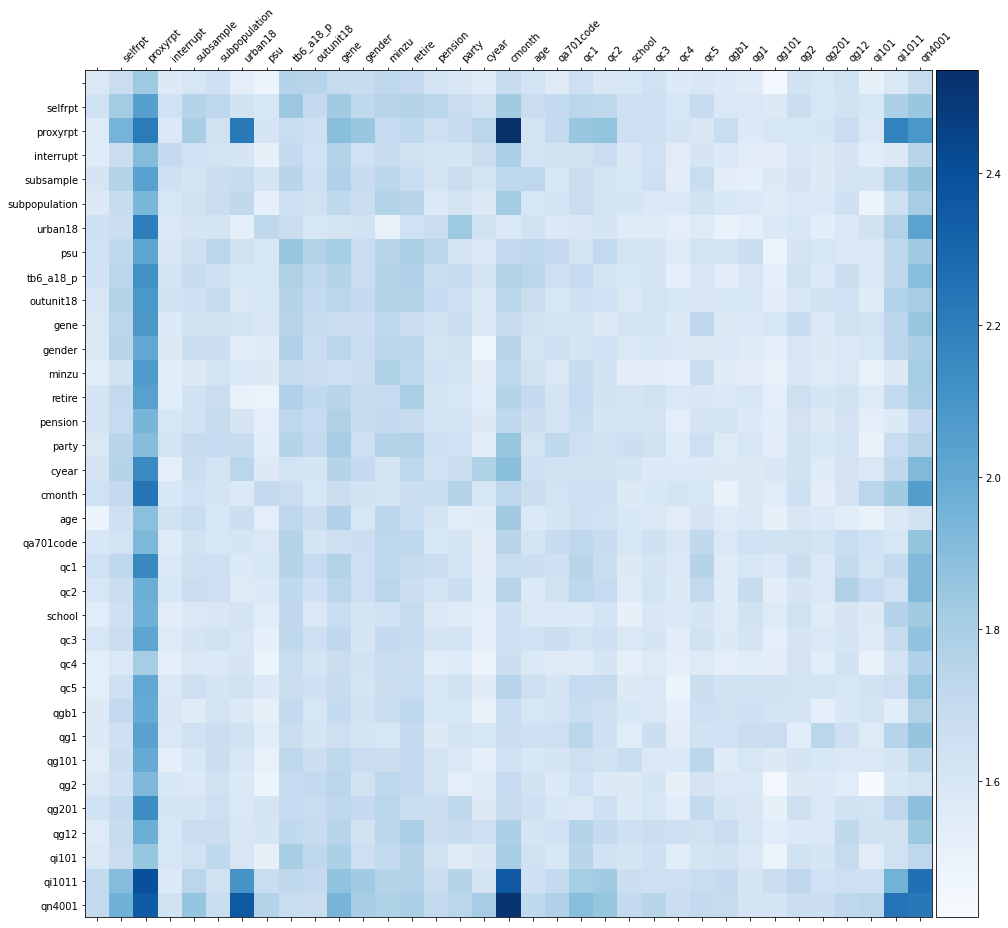

ListWrapper(['selfrpt', 'proxyrpt', 'interrupt', 'subsample', 'subpopulation', 'urban18', 'psu', 'tb6_a18_p', 'outunit18', 'gene', 'gender', 'minzu', 'retire', 'pension', 'party', 'cyear', 'cmonth', 'age', 'qa701code', 'qc1', 'qc2', 'school', 'qc3', 'qc4', 'qc5', 'qgb1', 'qg1', 'qg101', 'qg2', 'qg201', 'qg12', 'qi101', 'qi1011', 'qn4001', 'qp201'])


<Figure size 14400x14400 with 0 Axes>

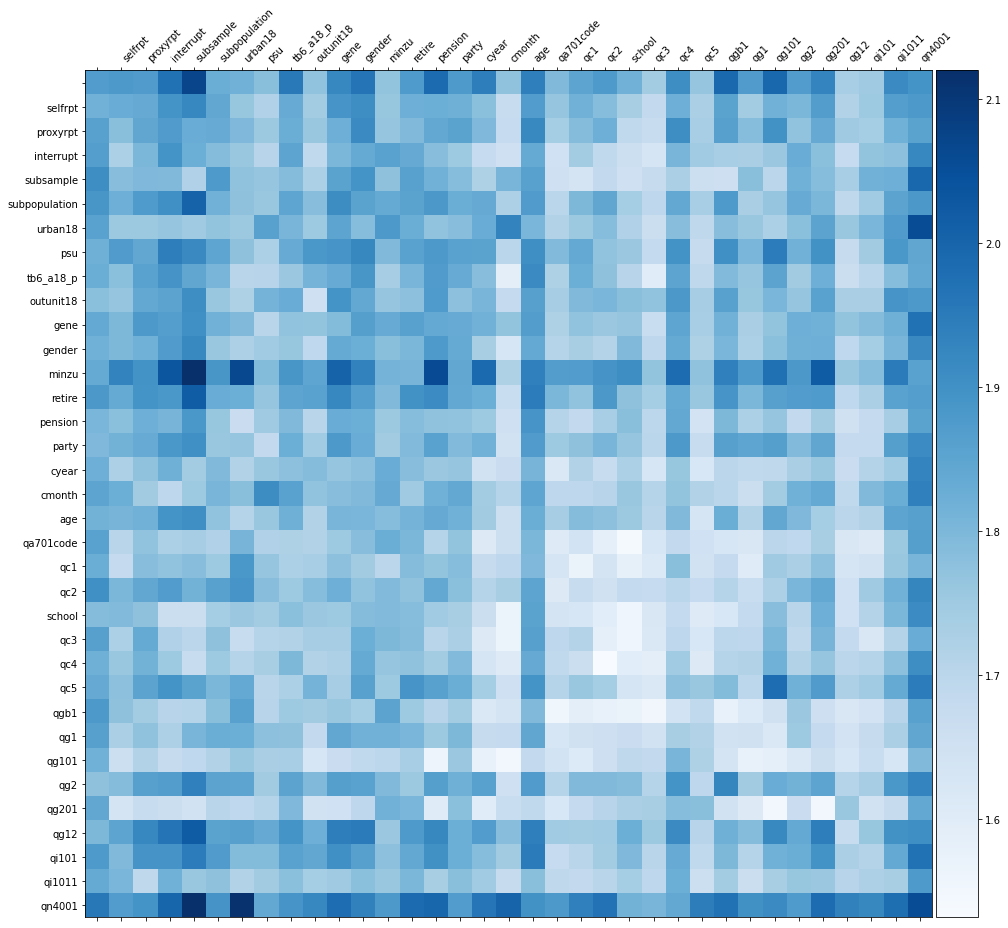

In [40]:
model = dcn_result["model"][0]

def visualize_feature_crossing(model):
    mat = model._cross_layer._dense.kernel
    features = model._all_features

    block_norm = np.ones([len(features), len(features)])

    dim = model.embedding_dimension

    # Compute the norms of the blocks.
    for i in range(len(features)):
        for j in range(len(features)):
            block = mat[i * dim:(i + 1) * dim,
                        j * dim:(j + 1) * dim]
            block_norm[i,j] = np.linalg.norm(block, ord="fro")

    print(features)

    plt.rcParams['figure.figsize'] = [20, 20]

    fig = plt.figure(figsize=(200,200))
    im = plt.matshow(block_norm, cmap=plt.cm.Blues)
    ax = plt.gca()
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    cax.tick_params(labelsize=10) 
    ax.set_xticks(np.arange(len(features)))
    ax.set_yticks(np.arange(len(features)))
    _ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
    _ = ax.set_yticklabels([""] + features, fontsize=10)
    plt.show()

visualize_feature_crossing(dcn_result["model"][0])
visualize_feature_crossing(dcn_result["model"][1])
visualize_feature_crossing(dcn_result["model"][2])